# sound celerity profile

Load CTD, Argo data and compute sound celerity (see also data cleaning in `clean_ctd_casts.ipynb`)

Compute also plausible pertubations of the oceanic stratification based on vertical modes and expected internal tide signatures

In [1]:
import matplotlib.pyplot as plt

import gsw

# cognac data and tools
import cognac.insitu as iu

---

# load data

In [2]:
# select campaign

campaign = 'sumos21'

cp = iu.campaign(campaign)

ctd = cp.load(None, unit="ctd")
argo = cp.load("argo")
floats = set(argo.PLATFORM_NUMBER.values)

### plot map with dates

Argo floats (purple on map below) are far away and may not be good indicators of the local stratification:

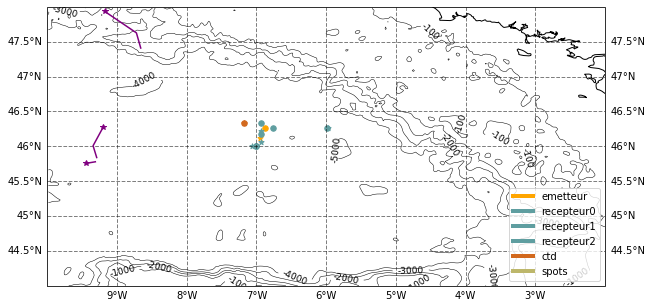

In [3]:
#fig, ax = plt.subplots(1, 1, figsize=(5,5))

fac = cp.plot_map(coast="10m", 
                  bounds=[-10, -2, 44, 48], 
                  levels=[-5000, -4000, -3000, -2000, -1000, -100],
                 )

ax = fac[1]

#for d in cp["ctd"]:
#    d.plot_on_map(fac[1], label='ctd_'+d.label, color=cp["ctd"]['color'])

    
for uname, unit in cp.items():
    if uname=="ship":
        continue
    for d in unit:
        line=False
        if unit=='source':
            yshift=2
        else:
            yshift=0.
        if d.label!='j0':
            d.plot_on_map(fac[1], line=line, label="", color=unit['color'], 
                     yshift=yshift)


for f in floats:
    _ds = argo.where(argo.PLATFORM_NUMBER==f, drop=True)
    hdl = ax.plot(_ds.LONGITUDE, _ds.LATITUDE, color = "purple", 
                  label="argo_"+str(f))
    ax.plot(_ds.LONGITUDE[-1], _ds.LATITUDE[-1], 
            color = "purple", 
            marker='*',
           )

cp.add_legend(fac[1], loc=4)

### look at hydrographic profiles

Text(0.5, 1.0, 'sound_speed')

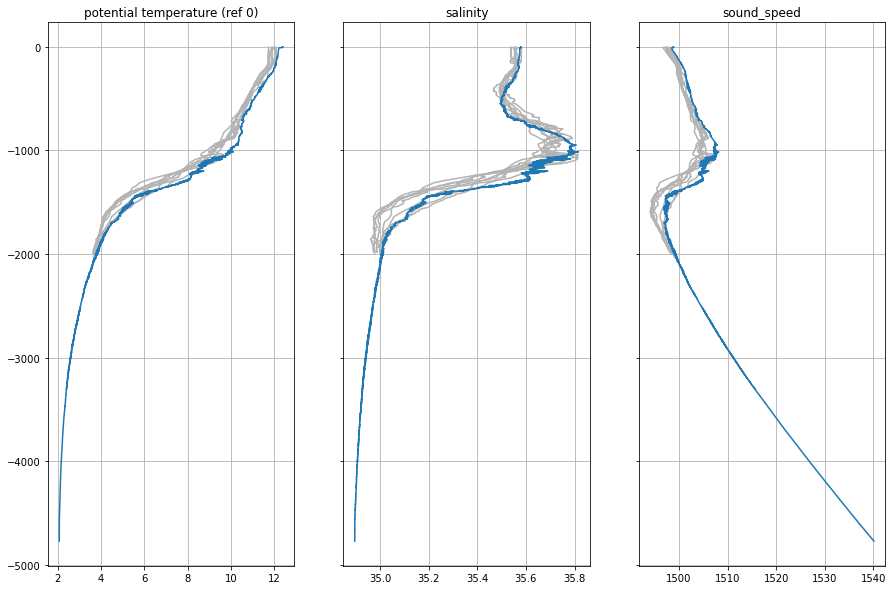

In [4]:
_ctd = ctd["ctd"]["d1"]
d = _ctd.d_depth.reset_index()
pt = gsw.conversions.pt_from_CT(d.SA, d.CT)


argo['potential_temperature'] = (('N_PROF','N_LEVELS'), 
                                 gsw.conversions.pt_from_CT(argo.SA, argo.CT),
                                )


fig, axes = plt.subplots(1,3, figsize=(15,10), sharey=True)

ax = axes[0]
for p in argo.N_PROF:
    a = argo.sel(N_PROF=p)
    ax.plot(a.potential_temperature, -a.PRES, color="0.7")
ax.plot(pt, -d.pressure)
ax.grid()
ax.set_title("potential temperature (ref 0)")

ax = axes[1]
for p in argo.N_PROF:
    a = argo.sel(N_PROF=p)
    ax.plot(a.PSAL, -a.PRES, color="0.7")
ax.plot(d.salinity, -d.pressure)
ax.grid()
ax.set_title("salinity")

ax = axes[2]
for p in argo.N_PROF:
    a = argo.sel(N_PROF=p)
    ax.plot(a.sound_speed, -a.PRES, color="0.7")
ax.plot(d.sound_speed, -d.pressure)
ax.grid()
ax.set_title("sound_speed")

### sensitivity to smoothing of the vertical profile

In [5]:
_ctd = ctd["ctd"]["d1"]
_ctd

In [6]:
from copy import deepcopy
import numpy as np

def smooth(ctd, bin_size):
    _ctd = deepcopy(ctd)
    d = _ctd.d_depth.reset_index()
    p = np.round(d["pressure"]/bin_size)
    _ctd.d_depth = d.groupby(by=p).mean().set_index("pressure")
    _ctd._update_eos()
    return _ctd

_ctd = ctd["ctd"]["d1"]

ctd_smoothed = {dp: smooth(_ctd, dp) for dp in [5,10,20,40]}

Text(0.5, 1.0, 'sound_speed')

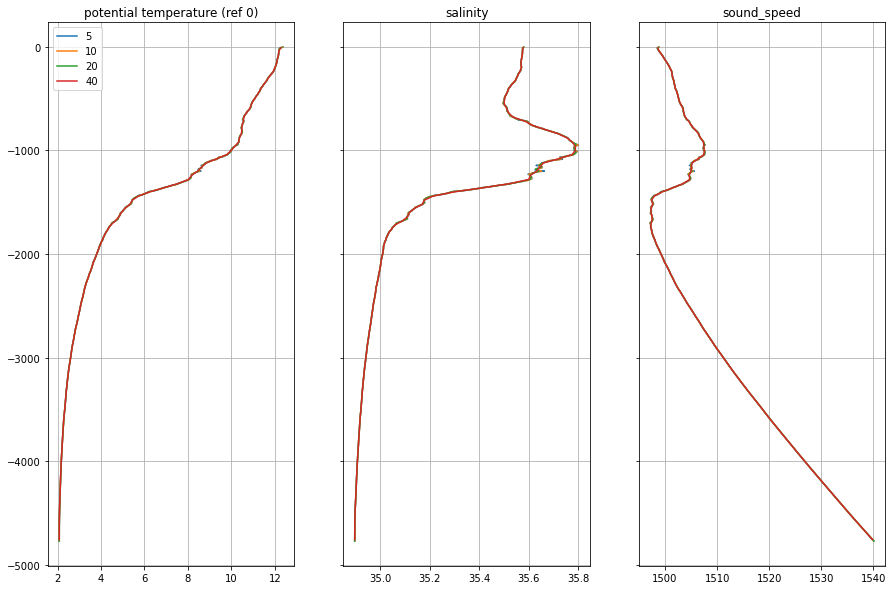

In [7]:
ylim = [-1200, -1000]
lims = False

fig, axes = plt.subplots(1,3, figsize=(15,10), sharey=True)

ax = axes[0]
for label, c in ctd_smoothed.items():
    d = c.d_depth.reset_index()
    pt = gsw.conversions.pt_from_CT(d.SA, d.CT)
    ax.plot(pt, -d.pressure, label=label)
ax.grid()
if lims:
    ax.set_ylim(ylim)
    ax.set_xlim(8,11)
ax.set_title("potential temperature (ref 0)")
ax.legend()

ax = axes[1]
for label, c in ctd_smoothed.items():
    d = c.d_depth.reset_index()
    ax.plot(d.salinity, -d.pressure)
ax.grid()
if lims:
    ax.set_ylim(ylim)
    #ax.set_xlim(8,11)
ax.set_title("salinity")

ax = axes[2]
for label, c in ctd_smoothed.items():
    d = c.d_depth.reset_index()
    ax.plot(d.sound_speed, -d.pressure)
ax.grid()
if lims:
    ax.set_ylim(ylim)
    #ax.set_xlim(8,11)
ax.set_title("sound_speed")

Text(0.5, 1.0, 'sound_speed')

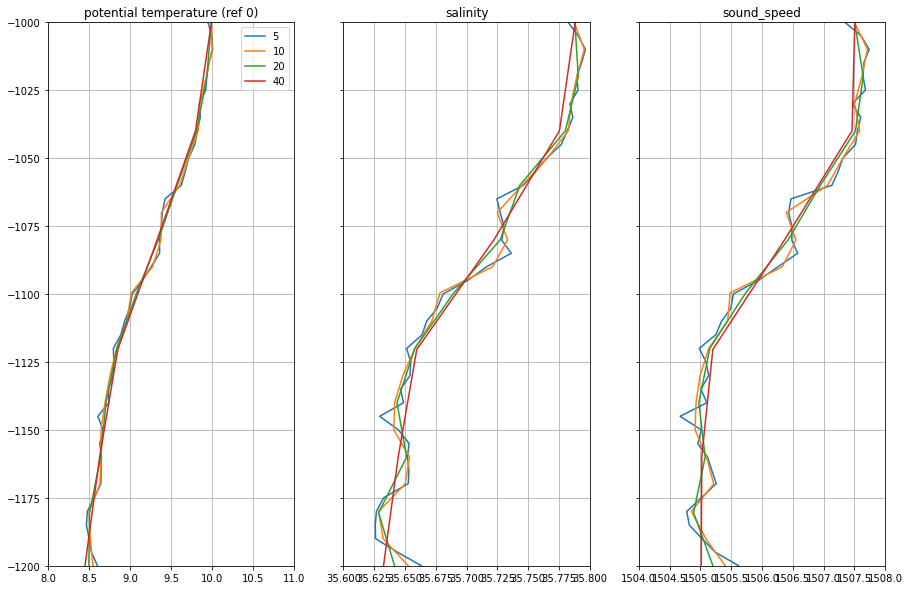

In [8]:
ylim = [-1200, -1000]
lims = True

fig, axes = plt.subplots(1,3, figsize=(15,10), sharey=True)

ax = axes[0]
for label, c in ctd_smoothed.items():
    d = c.d_depth.reset_index()
    pt = gsw.conversions.pt_from_CT(d.SA, d.CT)
    ax.plot(pt, -d.pressure, label=label)
ax.grid()
if lims:
    ax.set_ylim(ylim)
    ax.set_xlim(8,11)
ax.set_title("potential temperature (ref 0)")
ax.legend()

ax = axes[1]
for label, c in ctd_smoothed.items():
    d = c.d_depth.reset_index()
    ax.plot(d.salinity, -d.pressure)
ax.grid()
if lims:
    ax.set_ylim(ylim)
    ax.set_xlim(35.6, 35.8)
ax.set_title("salinity")

ax = axes[2]
for label, c in ctd_smoothed.items():
    d = c.d_depth.reset_index()
    ax.plot(d.sound_speed, -d.pressure)
ax.grid()
if lims:
    ax.set_ylim(ylim)
    ax.set_xlim(1504, 1508)
ax.set_title("sound_speed")

**Selected profile**

We decide to average hydrographic data on a 10m vertical grid

In [9]:
ctd = ctd_smoothed[20]

In [10]:
### compute vertical modes

import xarray as xr
import scipy.sparse as sp
import scipy.sparse.linalg as la

def compute_vmodes_1D(zc, zf, N2f, 
                      nmodes=5, free_surf=True, 
                      g=9.81, sigma=.1):
    """
    Compute vertical modes from stratification.

    Parameters:
    ___________
    zc: (N) ndarray
        vertical grid at cell centers
    zf: (N+1) ndarray
        vertical grid at cell interfaces
    N2f: (N+1) ndarray
        Brunt-Vaisala frequency at cell interfaces
    nmodes: int, optional
        number of baroclinic modes to compute (barotropic mode will be added)
    free_surf: bool, optional
        whether using a free-surface condition or rigid lid
    g: float, optional
        gravity constant
    sigma: float, optional
        parameter for shift-invert method in scipy.linalg.eig (default: _sig)

    Returns:
    ________
    c: (nmodes) ndarray
        eigenvalues (pseudo phase speed, c=1/sqrt(k))
    phi: (N,nmodes) ndarray
        p-like modes at cell centers
    dphidz: (N+1,nmodes) ndarray
        w-like modes at cell interfaces

    Notes:
    ______
    copy-pasted from M. Dunphy's vmodes_MD.py
    WARNING maybe the barotropic mode for rigid lid is wrong 
    The vertical modes are definied following the equation:
    .. math:: (\phi'/N^2)' + k^2\phi=0 
    with boundary condition :math:`\phi'=0` at the bottom and :math:`g\phi' + N^2\phi=0` at the surface (or :math:`\phi'=0` for a rigid lid condition). 
    Computation of the vertical modes is performed using second order finite difference

    """ 
    # Precompute a few quantities
    assert zc.ndim==zf.ndim==N2f.ndim==1
    assert len(zc)+1==len(N2f)==len(zf)
    dzc=np.diff(zc)
    dzf=np.diff(zf)
    Np=len(zf) #self.zf)
    N20=N2f[-1] #self.N2f[-1]  # N^2(z=0)
    H = abs(zf[0])
    
    # Build Dz, C-to-F grid 
    v1=-1.0/np.concatenate([dzc,np.ones(1)])
    v2= 1.0/np.concatenate([np.ones(1),dzc])
    v12=np.stack([v1, v2])
    Dz=sp.spdiags(v12,[-1, 0],Np,Np-1,format="lil")
    # Adjust matrix for BCs
    Dz[0,:]=0
    Dz[-1,:]=0
    if free_surf:
        Dz[-1,-1]=np.divide(-N20, g + N20*(zf[-1] - zc[-1]))

    # Build Dz2, F-to-C grid
    v1=-1.0/np.concatenate([dzf,np.ones(1)])
    v2= 1.0/np.concatenate([np.ones(1),dzf])
    v12=np.stack([v1,v2])
    Dz2=sp.spdiags(v12,[0, 1],Np-1,Np,format="lil")
    
    # Construct A, solve eigenvalue problem
    iN2=sp.spdiags(1.0/N2f,0,Np,Np)
    A=-Dz2*iN2*Dz
    ev,ef = la.eigs(A.tocsc(),nmodes+1,sigma=sigma)
    ev,ef = np.real(ev), np.real(ef)
    
    # Convert eigvenvalues to c_e, sort appropriately
    c=1.0/np.sqrt(np.real(ev))
    ii=(-c).argsort()
    c=c[ii]               # c_e value
    phic=ef[:,ii]         # phi at cell centres

    # Normalize and set surface value positive
    for mi in range(nmodes+1):
        fn=phic[:,mi]        # current phi
        s=np.sign(fn[-1])         # sign at surface
        if s==0:
            s=1;
        tmp = np.sum((fn**2)*dzf)/H
        phic[:,mi] = s*fn/np.sqrt(tmp) # (1/H)*\int_{-H}^{0} \phi_m(z)^2 dz = 1
        
    # dphi at cell faces: phi'=dphidz (buoyancy modes)
    dphif = Dz*phic
    # this would give w-modes: np.r_[np.zeros((1,nmodes+1)),(dzf[:,None]*phic).cumsum(axis=0)]
    return c, phic, dphif


In [11]:
d = ctd.d_depth.reset_index()
N2, p_N2 = gsw.Nsquared(d.SA, d.CT, d.pressure)

# massage arrays
N2 = np.hstack((N2[0], N2))[::-1]
zf = np.hstack((0, -p_N2))[::-1]
zc = -d.pressure[:-1].values[::-1]

# and compute vertical modes
c, phi, dphidz = compute_vmodes_1D(zc, zf, N2)

# massage into xarray
vm = xr.Dataset(dict(c=("mode", c), 
                     phi=(("zc", "mode"), phi), 
                     dphidz=(("zf", "mode"), dphidz),
                     N2=("zf", N2),
                     CT=("zc", d.CT[:-1][::-1]),
                     SA=("zc", d.SA[:-1][::-1]),
                    ),
                coords=dict(zc=("zc", zc), zf=("zf", zf)),
               )
vm

<xarray.Dataset>
Dimensions:  (mode: 6, zc: 239, zf: 240)
Coordinates:
  * zc       (zc) float64 -4.76e+03 -4.74e+03 -4.72e+03 ... -40.0 -20.0 -5.0
  * zf       (zf) float64 -4.766e+03 -4.75e+03 -4.73e+03 ... -30.0 -12.5 0.0
Dimensions without coordinates: mode
Data variables:
    c        (mode) float64 216.3 2.533 1.11 0.7106 0.5188 0.4217
    phi      (zc, mode) float64 1.0 -0.7823 0.8486 -0.6736 ... 1.476 1.362 1.687
    dphidz   (zf, mode) float64 0.0 0.0 0.0 ... -2.018e-06 -1.862e-06 -2.306e-06
    N2       (zf) float64 -6.195e-08 3.95e-09 2.556e-08 ... 1.341e-05 1.341e-05
    CT       (zc) float64 2.073 2.074 2.074 2.075 ... 12.16 12.17 12.19 12.31
    SA       (zc) float64 35.07 35.07 35.07 35.07 ... 35.74 35.74 35.74 35.75

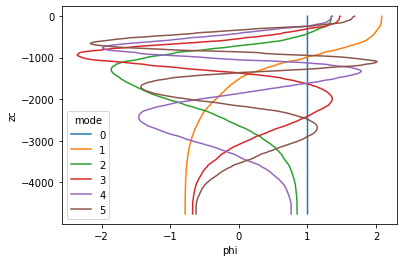

In [12]:
vm["phi"].plot.line(y="zc")

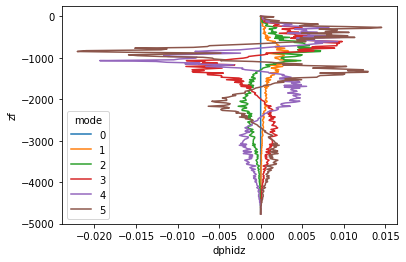

In [13]:
vm["dphidz"].plot.line(y="zf")

From sea level ($\eta_s$) to pressure ($p$) to isopycnal displacement ($\eta(z)$) to sound speed ($c$) anomalies:

$
\begin{align}
p(z=0) &= p_m \phi_m(0) = g \eta_s, \\
\rho(z) &= -\partial_z p /g = -p_m/g \times \partial_z \phi_m(z), \\
\eta(z) &= \rho/\partial_z \bar \rho, \\
&= p_m N^{-2} \partial_z \phi_m(z), \\
&= \eta_s \frac{g}{N^2\phi_m(0)} \partial_z \phi_m(z), \\
\end{align}
$



If the sea level is displaced by 2cm, the corresponding isopycnal displacements will be.

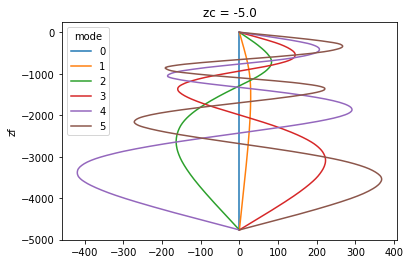

In [14]:
etas = 0.02

eta = etas*9.81/vm["N2"]*vm["dphidz"]/vm["phi"].isel(zc=-1)

eta.plot.line(y="zf")

The amplitude of the sea level fluctuation could be ajusted according to SUMOS spot observations (via currents and hypothesis about the vertical structure).
A numerical simulation of the area could also be helpful here.

### Compute now the sound celerity perturbation

We start from conservative temperature (CT) and absolute salinity (SA) profiles which we perturb with an isopycnal displacement computed above.
The perturbed sound celerity may be computed from the pertubed profiles of CT and SA and compared with the original profile

In [15]:
vm["z_original"] = vm.zc - eta.drop("zc").interp(zf=vm.zc)

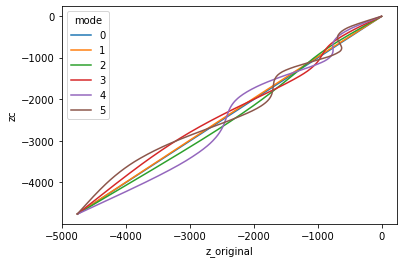

In [16]:
vm["z_original"].plot.line(y="zc")

In [17]:
perturb = lambda v: vm[v].interp(zc=vm["z_original"], 
                                 kwargs={"fill_value": "extrapolate"},
                                )

vm["CT_perturbed"] = perturb("CT")
vm["SA_perturbed"] = perturb("SA")

# compute sound celerity
vm["sound_speed"] = gsw.sound_speed(vm.SA, vm.CT, -vm.zc)
vm["sound_speed_perturbed"] = gsw.sound_speed(vm.SA_perturbed, vm.CT_perturbed, -vm.zc)

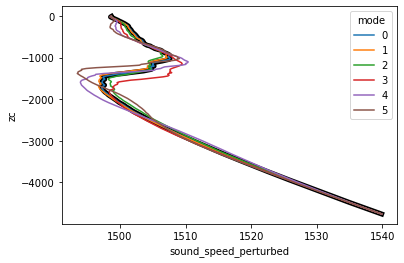

In [18]:
vm.sound_speed.plot.line(y="zc", color="k", lw=5)
vm.sound_speed_perturbed.plot.line(y="zc")

In [19]:
vm

<xarray.Dataset>
Dimensions:                (mode: 6, zc: 239, zf: 240)
Coordinates:
  * zc                     (zc) float64 -4.76e+03 -4.74e+03 ... -20.0 -5.0
  * zf                     (zf) float64 -4.766e+03 -4.75e+03 ... -12.5 0.0
Dimensions without coordinates: mode
Data variables:
    c                      (mode) float64 216.3 2.533 1.11 0.7106 0.5188 0.4217
    phi                    (zc, mode) float64 1.0 -0.7823 0.8486 ... 1.362 1.687
    dphidz                 (zf, mode) float64 0.0 0.0 ... -1.862e-06 -2.306e-06
    N2                     (zf) float64 -6.195e-08 3.95e-09 ... 1.341e-05
    CT                     (zc) float64 2.073 2.074 2.074 ... 12.17 12.19 12.31
    SA                     (zc) float64 35.07 35.07 35.07 ... 35.74 35.74 35.75
    z_original             (zc, mode) float64 -4.76e+03 -4.76e+03 ... -10.5
    CT_perturbed           (zc, mode) float64 2.073 2.073 2.073 ... 12.28 12.26
    SA_perturbed           (zc, mode) float64 35.07 35.07 35.07 ... 35.75 35.74
    sound_speed            (zc) float64 1.54e+03 1.54e+03 ... 1.499e+03
    sound_speed_perturbed  (zc, mode) float64 1.54e+03 1.54e+03 ... 1.499e+03

In [20]:
vm.to_netcdf("sound_speed_profile_{}.nc".format(cp.name), mode="w")